In [1]:
from rdkit import Chem 
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
size = (1000,1000) # width, height
from PIL import Image, ImageChops, ImageOps
def trim(im):
    bg = Image.new('RGBA', size, '#ffffff') # mode, size, color string
    diff = ImageChops.difference(im, bg)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

Draw.DrawingOptions.atomLabelFontSize = 12         # This is default vaule
Draw.DrawingOptions.dotsPerAngstrom = 40           # default is 30, bigger for fewer clash
Draw.DrawingOptions.bondLineWidth = 2.0            # defailt is 1.2, boloder for clarity
Draw.DrawingOptions.includeAtomNumbers=False    
mol2pil = lambda mol: trim(Draw.MolToImage(mol,size=size))

In [2]:
from rdkit.Chem import rdDepictor
from IPython.display import SVG  
import cairosvg 
import io
import numpy as np 

def relativeAtomPosition(mol):
    drawer = Draw.MolDraw2DSVG(*size)
    rdDepictor.Compute2DCoords(mol)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    png_bytes = cairosvg.svg2png(bytestring=drawer.GetDrawingText().encode('utf-8')) 
    
    img = Image.open(io.BytesIO(png_bytes)) 
    bg = Image.new('RGB', size, '#ffffff')             # mode, size, color string
    diff = ImageChops.difference(img, bg)
    left, upper, right, lower = diff.getbbox()         # left, upper, right, and lower  
    #display(SVG(drawer.GetDrawingText().replace("svg:",""))) 
    
    pos = [drawer.GetDrawCoords(atom.GetIdx()) for atom in mol.GetAtoms()]
    pos_x = [i.x for i in pos]
    pos_x = np.array(pos_x)
    pos_x = (pos_x - left) / (right - left)
    pos_y = [i.y for i in pos] 
    pos_y = np.array(pos_y)
    pos_y = (pos_y - upper) / (lower - upper)
    return pos_x, pos_y

In [3]:
pad_len=20
def newAtomPosition(mol, ref_img, pad_len=20):
    pos_x, pos_y = relativeAtomPosition(mol) 
    pos_x = pad_len + pos_x*ref_img.width
    pos_y = pad_len + pos_y*ref_img.height
    return pos_x, pos_y

In [4]:
def MolToConnectionTable(mol):
    s='' 
    for atom in mol.GetAtoms():
        s += str(atom.GetIdx()) + '\t' 
        for nba in atom.GetNeighbors(): 
            s += str(nba.GetIdx()) + '\t' 
        s += '\n' 
    return s 
MolToAtomSymbol = lambda mol: '_'.join([atom.GetSymbol() for atom in mol.GetAtoms()])

### Get Some Molecule

In [5]:
import pandas as pd
df = pd.read_csv('cid_num_smi.csv',header=None,delimiter='|')
df = df.head(100) 
display(df.head(5))
from rdkit.Chem.PandasTools import AddMoleculeColumnToFrame
AddMoleculeColumnToFrame(df, smilesCol= 2, molCol='ROMol')
SMILESs, mols = df[2],df['ROMol']
big_mol, small = mols[98], mols[1]

,0,1,2,3
0,1,14,CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C,NaN
1,2,14,CC(=O)OC(CC(=O)O)C[N+](C)(C)C,NaN
2,3,11,C1=CC(C(C(=C1)C(=O)O)O)O,NaN
3,4,5,CC(CN)O,NaN
4,5,10,C(C(=O)COP(=O)(O)O)N,NaN


### Show Them

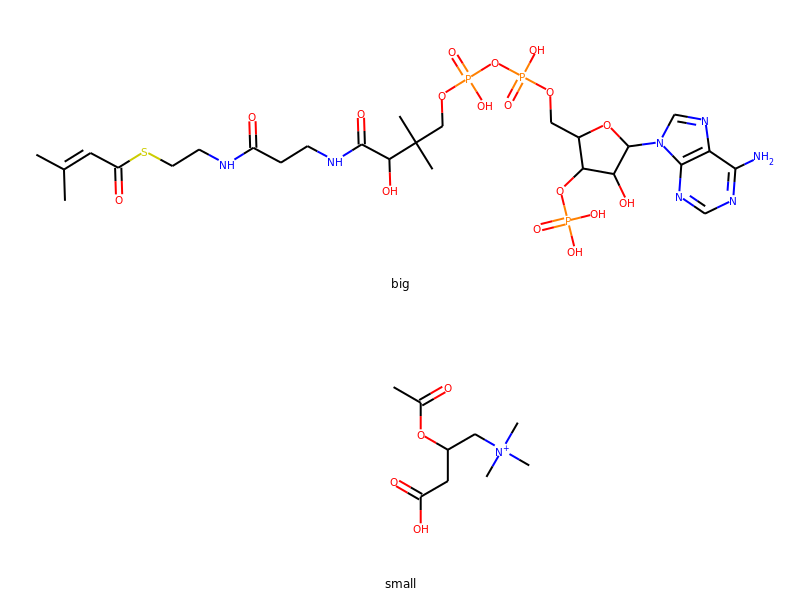

In [6]:
Chem.Draw.MolsToGridImage([big_mol, small], molsPerRow=1, subImgSize=(800,300), legends=['big', 'small'])

### Convert Mols to Images 

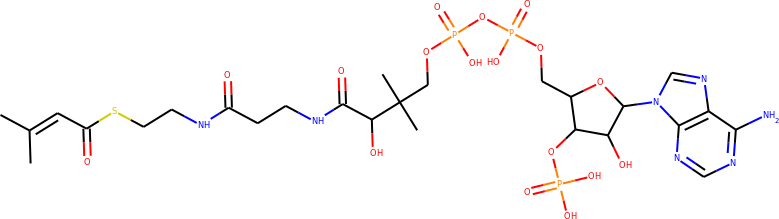

In [7]:
big_img = mol2pil(big_mol) 
big_img                    # Cropped

### Atom Positions are needed

In [8]:
pos_x, pos_y = newAtomPosition(big_mol, big_img, pad_len=20) 

### Pad the Images

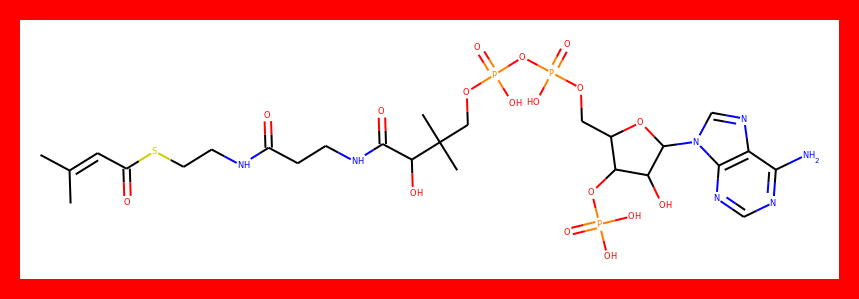

In [9]:
big_img = ImageOps.expand(big_img, border=pad_len, fill='#ffffff')
ImageOps.expand(big_img, border=pad_len, fill='#ff0000') # red is for illustration, white for reality

[ 20.39651838  49.63995658  77.82959602 107.07303422 108.12683298
 135.26267366 164.50611186 192.6957513  221.9391895  250.12882894
 249.07503018 279.37226714 307.56190658 336.80534479 364.99498423
 363.94118546 394.23842243 422.42806187 404.93594395 439.92017978
 450.61770131 449.56390255 477.75354199 460.26142407 495.2456599
 505.94318143 535.18661963 519.51973471 550.85350455 564.43005783
 565.48385659 594.72729479 599.24138034 631.89487649 647.56176141
 624.59093264 680.4289638  696.09584872 728.74934487 733.26343042
 703.39979257 700.9817589  728.42736308 758.29100093 760.7090346
 790.57267245 646.34455107 575.30456797 583.22948305 551.01418106
 615.44478503 591.15439812 395.29222119  50.69375534] [132.7037748  148.18862658 130.89974914 146.38460092 179.15833015
 129.09572348 144.58057527 127.29169782 142.77654961 125.48767216
  92.71394293 140.97252395 123.6836465  139.16849829 121.87962084
  89.10589161 137.36447263 120.07559519  92.21349045 147.93769992
 102.78671774  70.012988

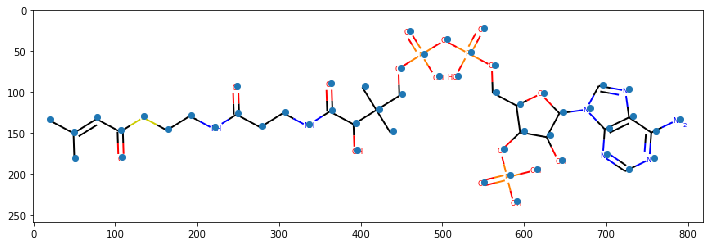

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
imgplot = plt.imshow(big_img)
imgplot.figure.set_figheight(12)
imgplot.figure.set_figwidth(12)
print(pos_x, pos_y)
plt.scatter(pos_x, pos_y)

In [11]:
big_img.save('image/'+'sample.png')

#### All in One

In [12]:
def allInOne(mol, name='sample.png', pad_len=20):
    img = mol2pil(mol)
    pos_x, pos_y = newAtomPosition(mol, img, pad_len=pad_len) 
    new_img = ImageOps.expand(img, border=pad_len, fill='#ffffff')
    new_img.save(name)  
    return pos_x, pos_y 

### Conn Table

0	1	
1	0	2	53	
2	1	3	
3	2	4	5	
4	3	
5	3	6	
6	5	7	
7	6	8	
8	7	9	
9	8	10	11	
10	9	
11	9	12	
12	11	13	
13	12	14	
14	13	15	16	
15	14	
16	14	17	52	
17	16	18	19	20	
18	17	
19	17	
20	17	21	
21	20	22	
22	21	23	24	25	
23	22	
24	22	
25	22	26	
26	25	27	28	29	
27	26	
28	26	
29	26	30	
30	29	31	
31	30	32	35	
32	31	33	47	
33	32	34	46	
34	33	35	36	
35	34	31	
36	34	37	40	
37	36	38	
38	37	39	
39	38	40	44	
40	39	41	36	
41	40	42	
42	41	43	
43	42	44	
44	43	45	39	
45	44	
46	33	
47	32	48	
48	47	49	50	51	
49	48	
50	48	
51	48	
52	16	
53	1	

C_C_C_C_O_S_C_C_N_C_O_C_C_N_C_O_C_C_C_C_C_O_P_O_O_O_P_O_O_O_C_C_C_C_C_O_N_C_N_C_C_N_C_N_C_N_O_O_P_O_O_O_O_C


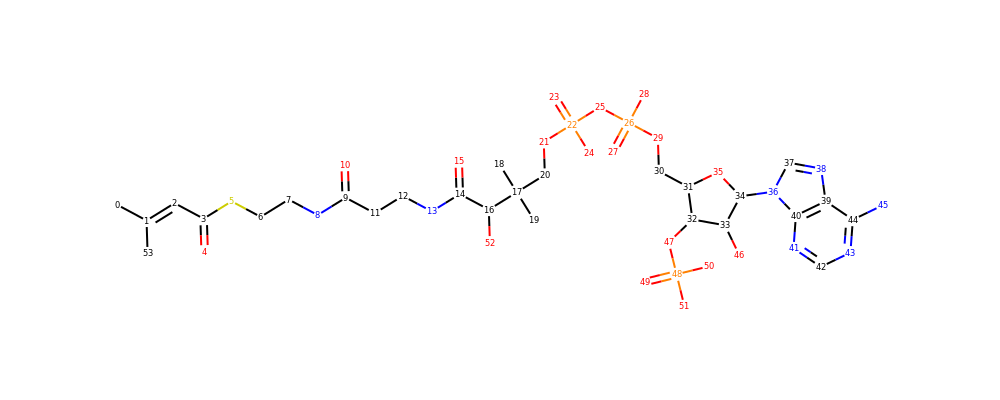

In [13]:
print(MolToConnectionTable(big_mol))
print(MolToAtomSymbol(big_mol))
Chem.Draw.MolToImage(big_mol,size=(1000, 400), includeAtomNumbers=True)

## Dataset Generation

In [ ]:
dataset = pd.DataFrame(columns=['cid','smi','connTbl','syb', 'x', 'y'])
for cid, smi, mol in zip(df[0], df[2], df['ROMol']):
    connTbl = MolToConnectionTable(mol)
    syb = MolToAtomSymbol(mol)
    x, y = allInOne(mol, name='image/'+str(cid)+'.png')
    dataset = dataset.append({'cid':cid,'smi':smi,'connTbl':connTbl,'syb':syb, 'x':x, 'y':y}, ignore_index=True)

dataset.to_pickle('dataset.pkl')